# Hourly Energy Consumption Forecasting

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

### Importing Dataset as Pandas DataFrame

In [2]:
df = pd.read_csv("data.csv")

### About Dataset
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

``PJM East Region: 2001-2018 (PJME)``

- estimated energy consumption in Megawatts (MW)

### EDA

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df = df.set_index('Datetime')

In [5]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [6]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [7]:
df.shape

(145366, 1)

In [8]:
round(df.describe(),2)

,PJME_MW
count,145366.00
mean,32080.22
std,6464.01
min,14544.00
25%,27573.00
50%,31421.00
75%,35650.00
max,62009.00


In [9]:
df.index.dtype

dtype('O')

In [10]:
df.index = pd.to_datetime(df.index)

In [11]:
df.index.dtype

dtype('<M8[ns]')

In [12]:
color_pal = sns.color_palette()

Text(0, 0.5, 'Hourly Energy Consumption (MW)')

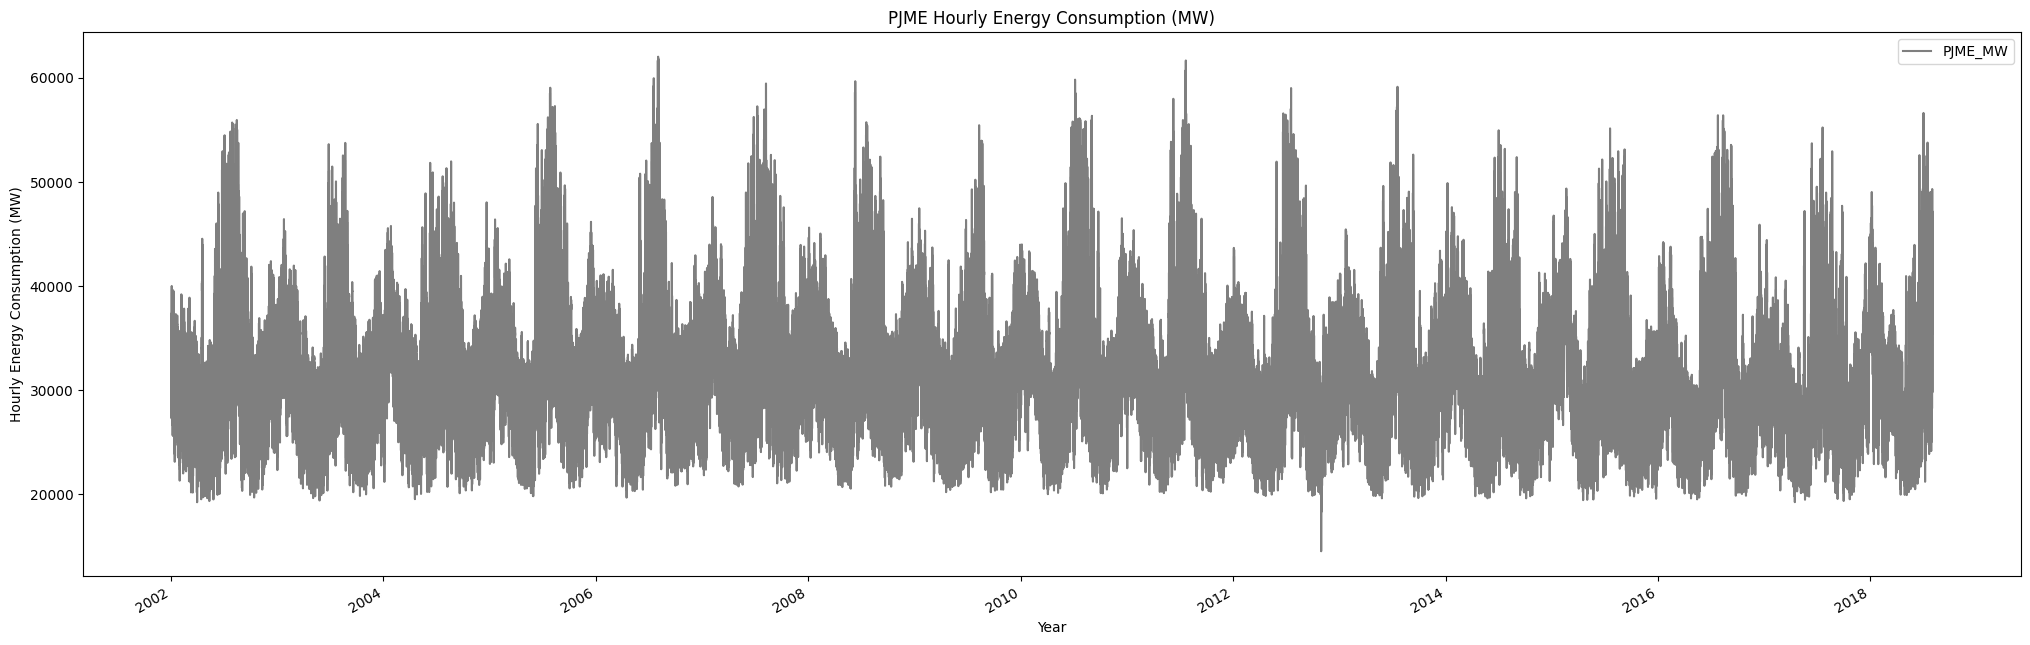

In [13]:
df.plot(figsize=(25,8),title="PJME Hourly Energy Consumption (MW)",color=color_pal[7])
plt.xlabel("Year")
plt.ylabel("Hourly Energy Consumption (MW)")

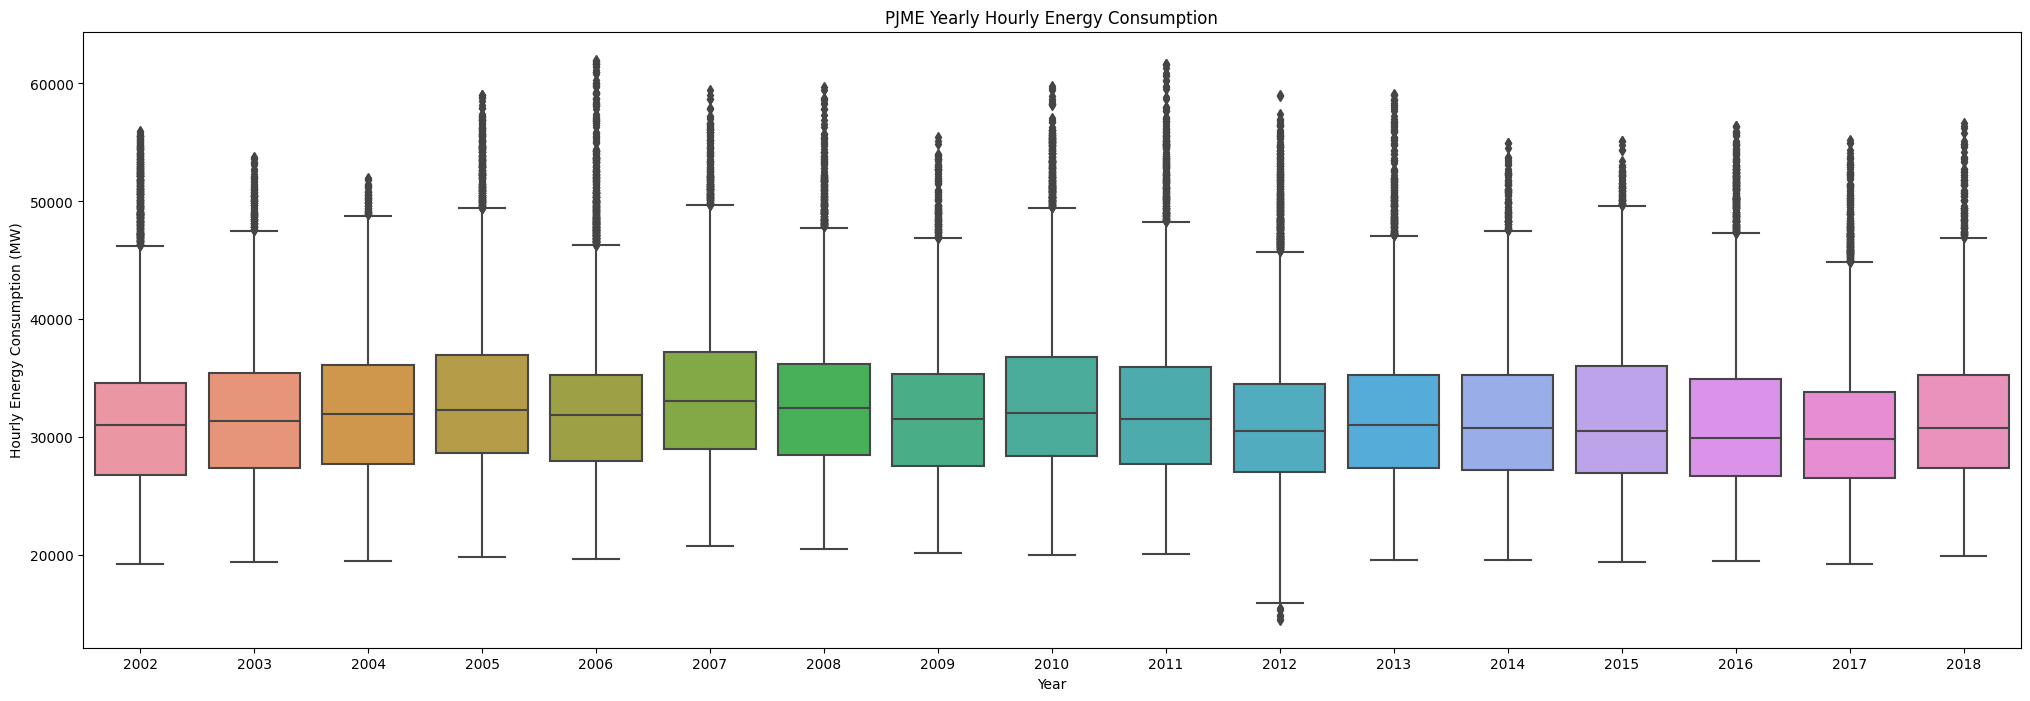

In [14]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.year,y = df['PJME_MW'].values,ax=ax)
plt.title("PJME Yearly Hourly Energy Consumption")
plt.xlabel("Year")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.show()

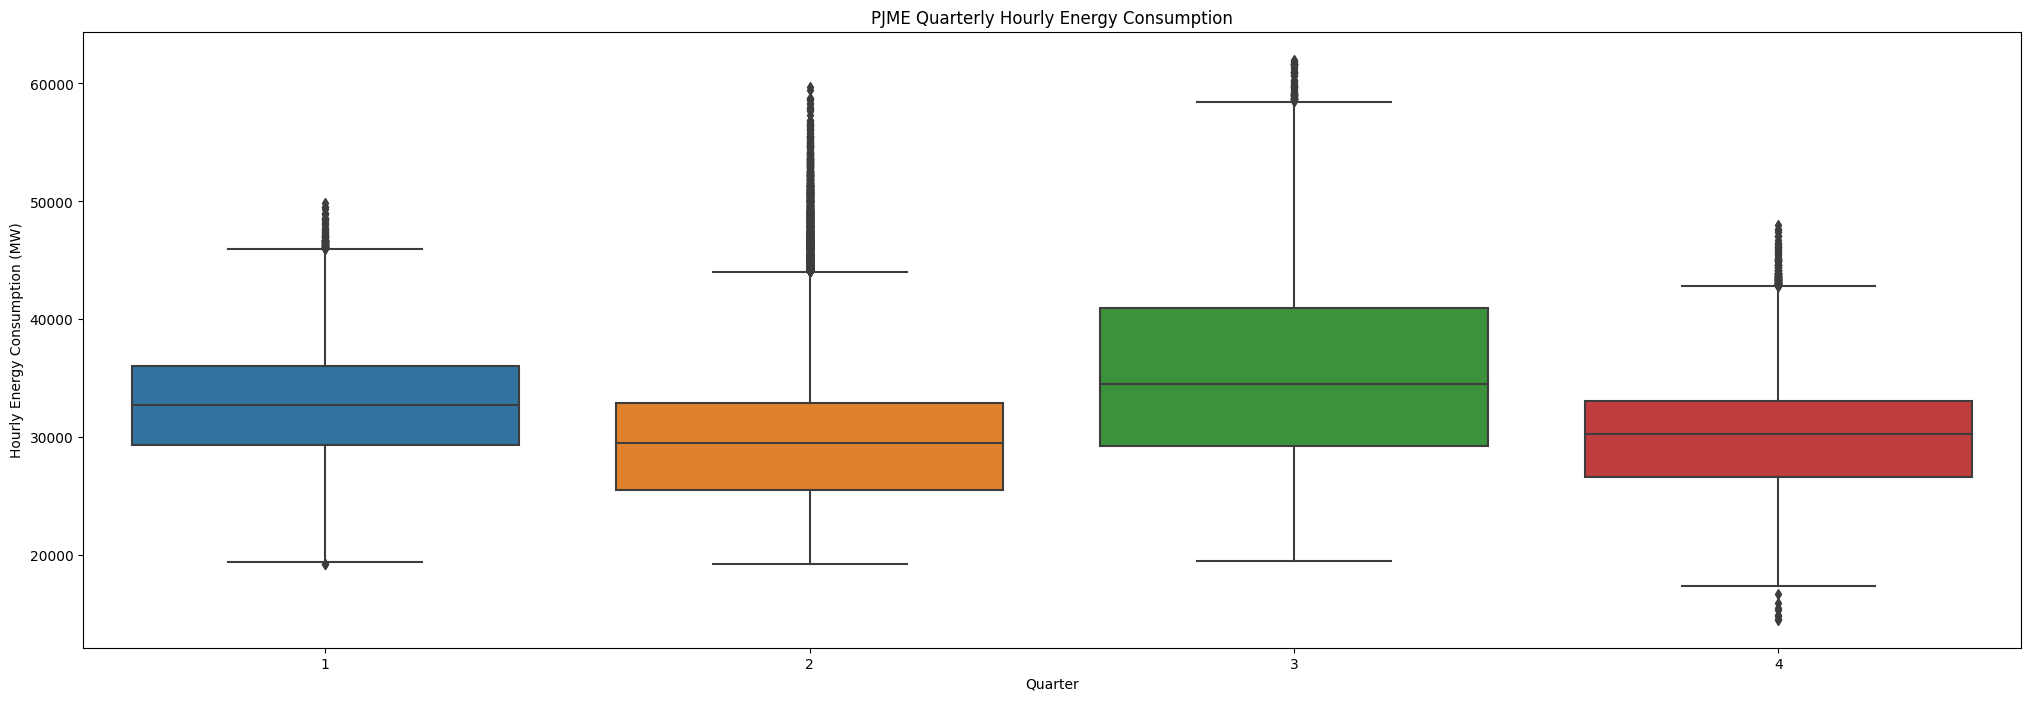

In [15]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.quarter,y = df['PJME_MW'].values,ax=ax)
plt.title("PJME Quarterly Hourly Energy Consumption")
plt.xlabel("Quarter")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.show()

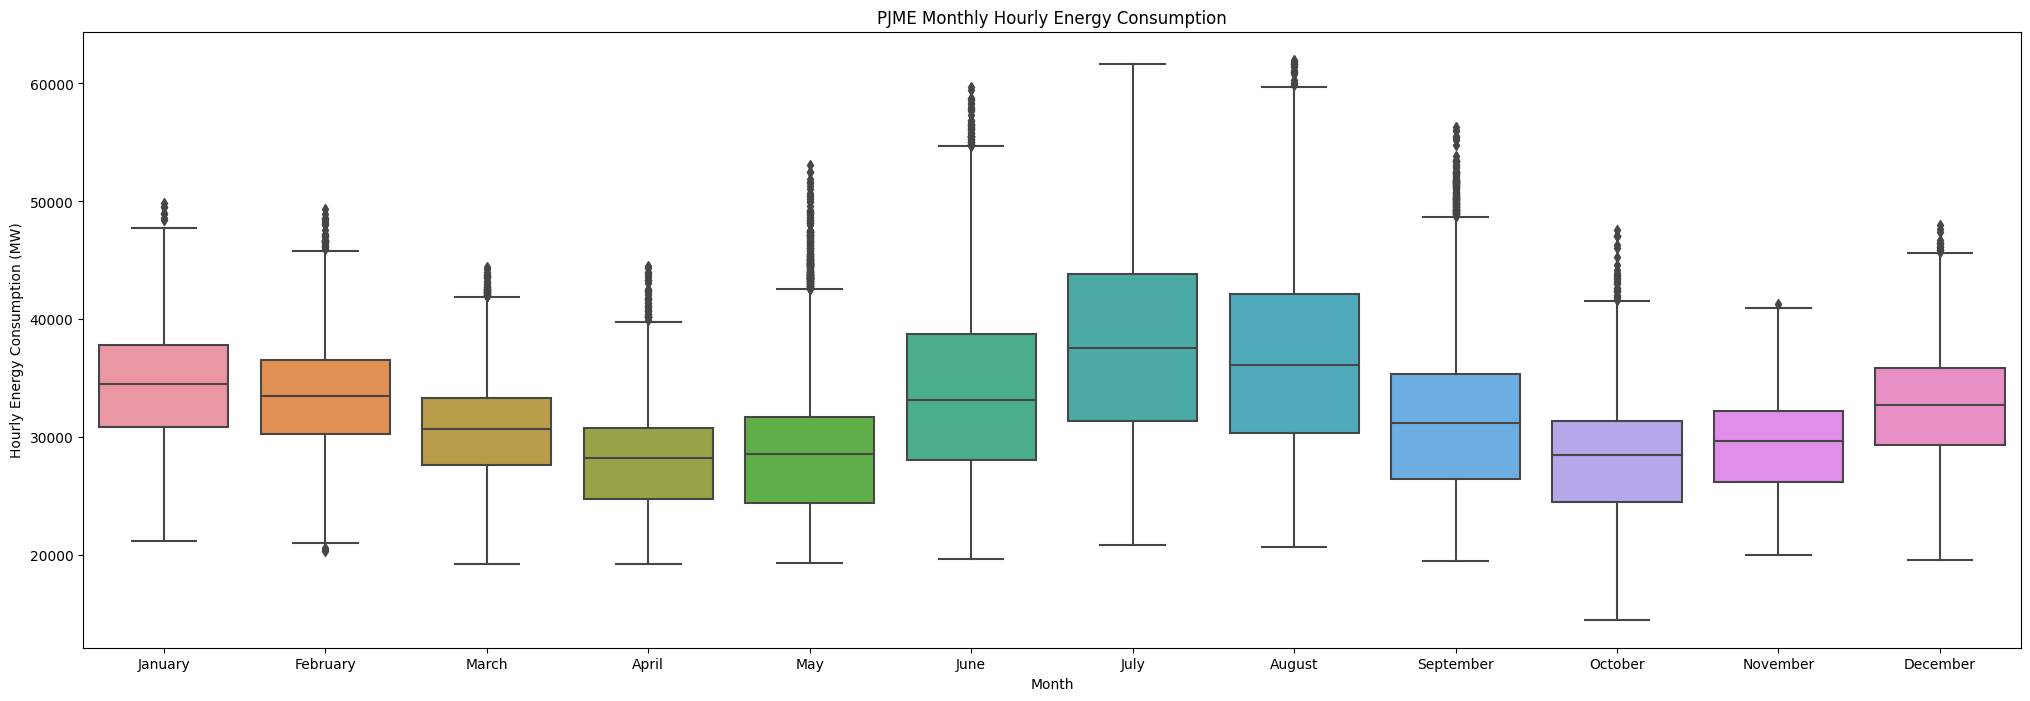

In [16]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.month_name(),
            y = df['PJME_MW'].values,
            ax=ax,
            order = ['January', 'February', 'March', 'April', 'May', 'June',
                     'July', 'August', 'September', 'October', 'November', 'December'])
plt.title("PJME Monthly Hourly Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.show()

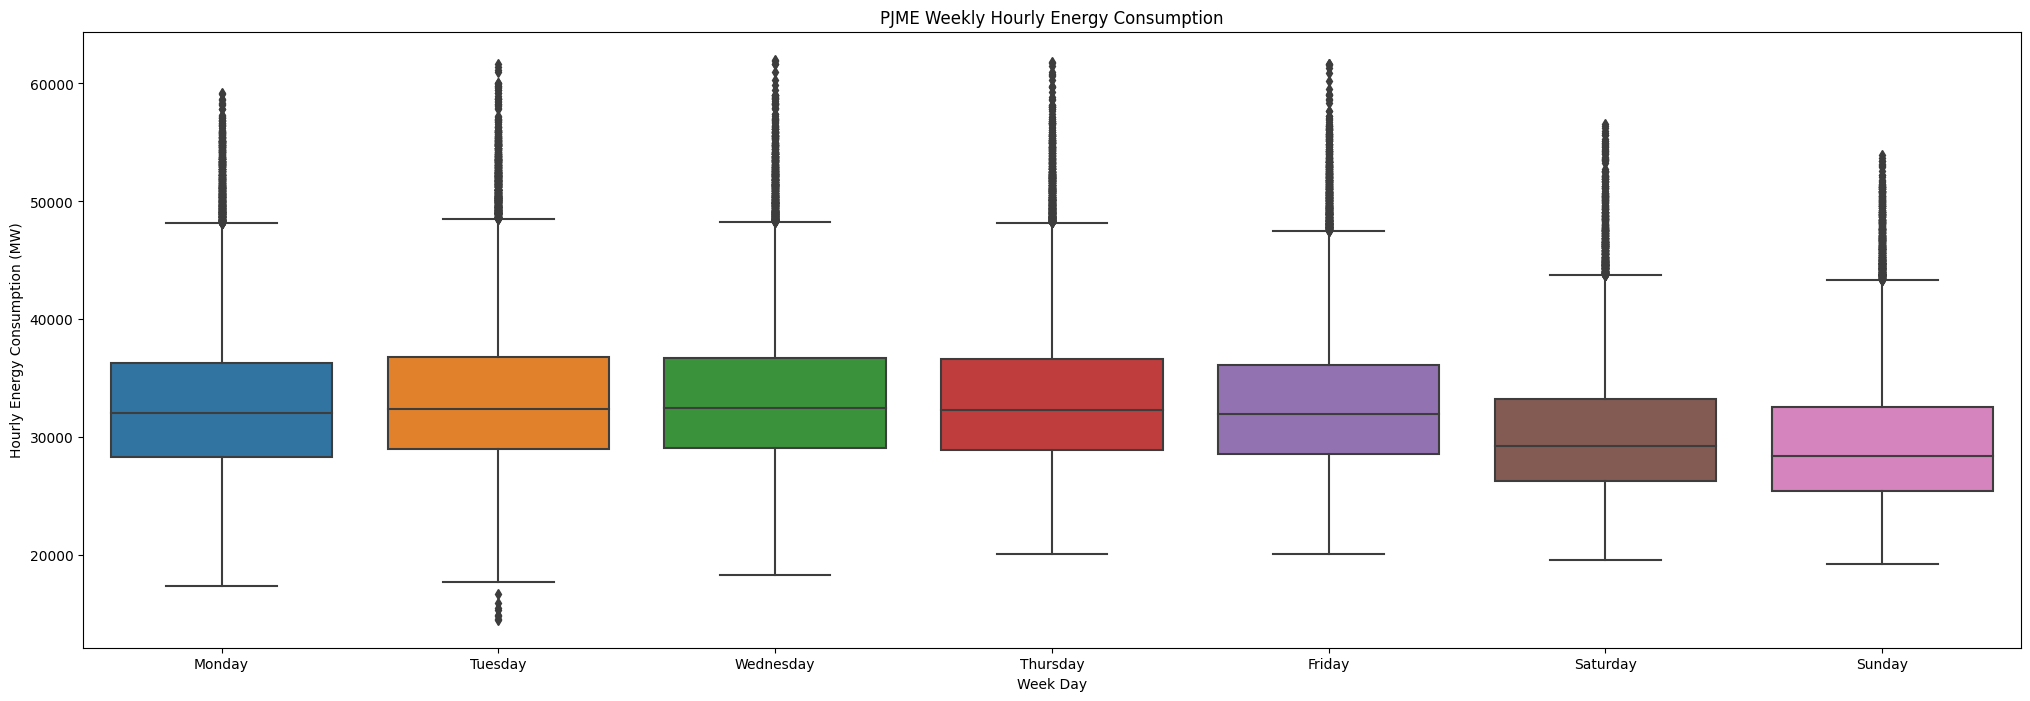

In [17]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.day_name(),
            y = df['PJME_MW'].values,
            ax=ax,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("PJME Weekly Hourly Energy Consumption")
plt.xlabel("Week Day")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.show()

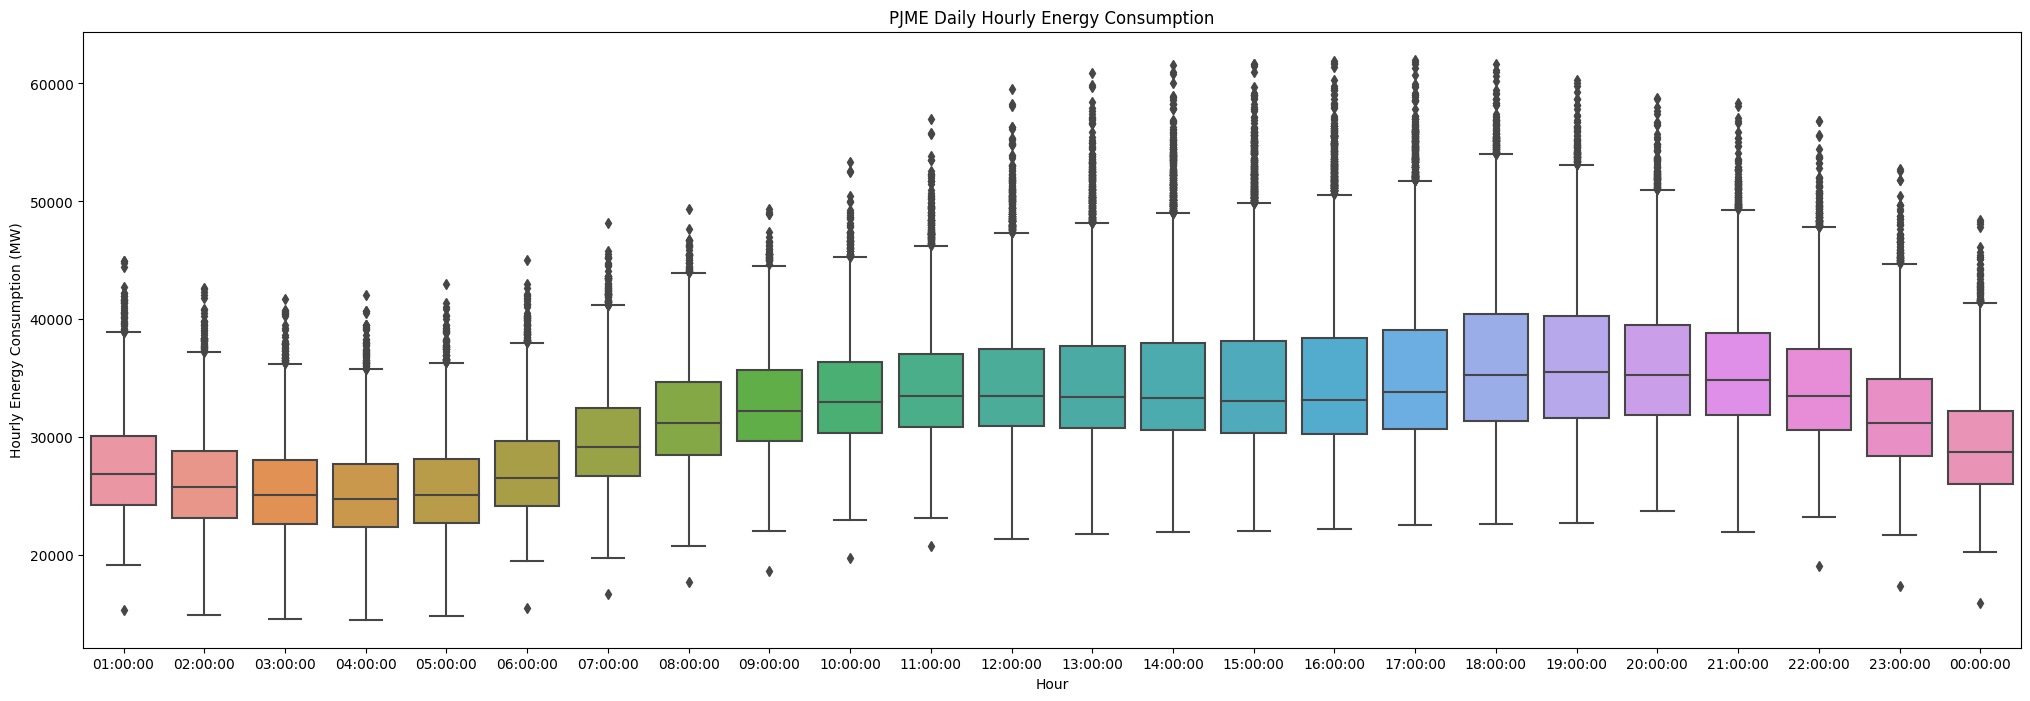

In [18]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.time,y = df['PJME_MW'].values,ax=ax)
plt.title("PJME Daily Hourly Energy Consumption")
plt.xlabel("Hour")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.show()

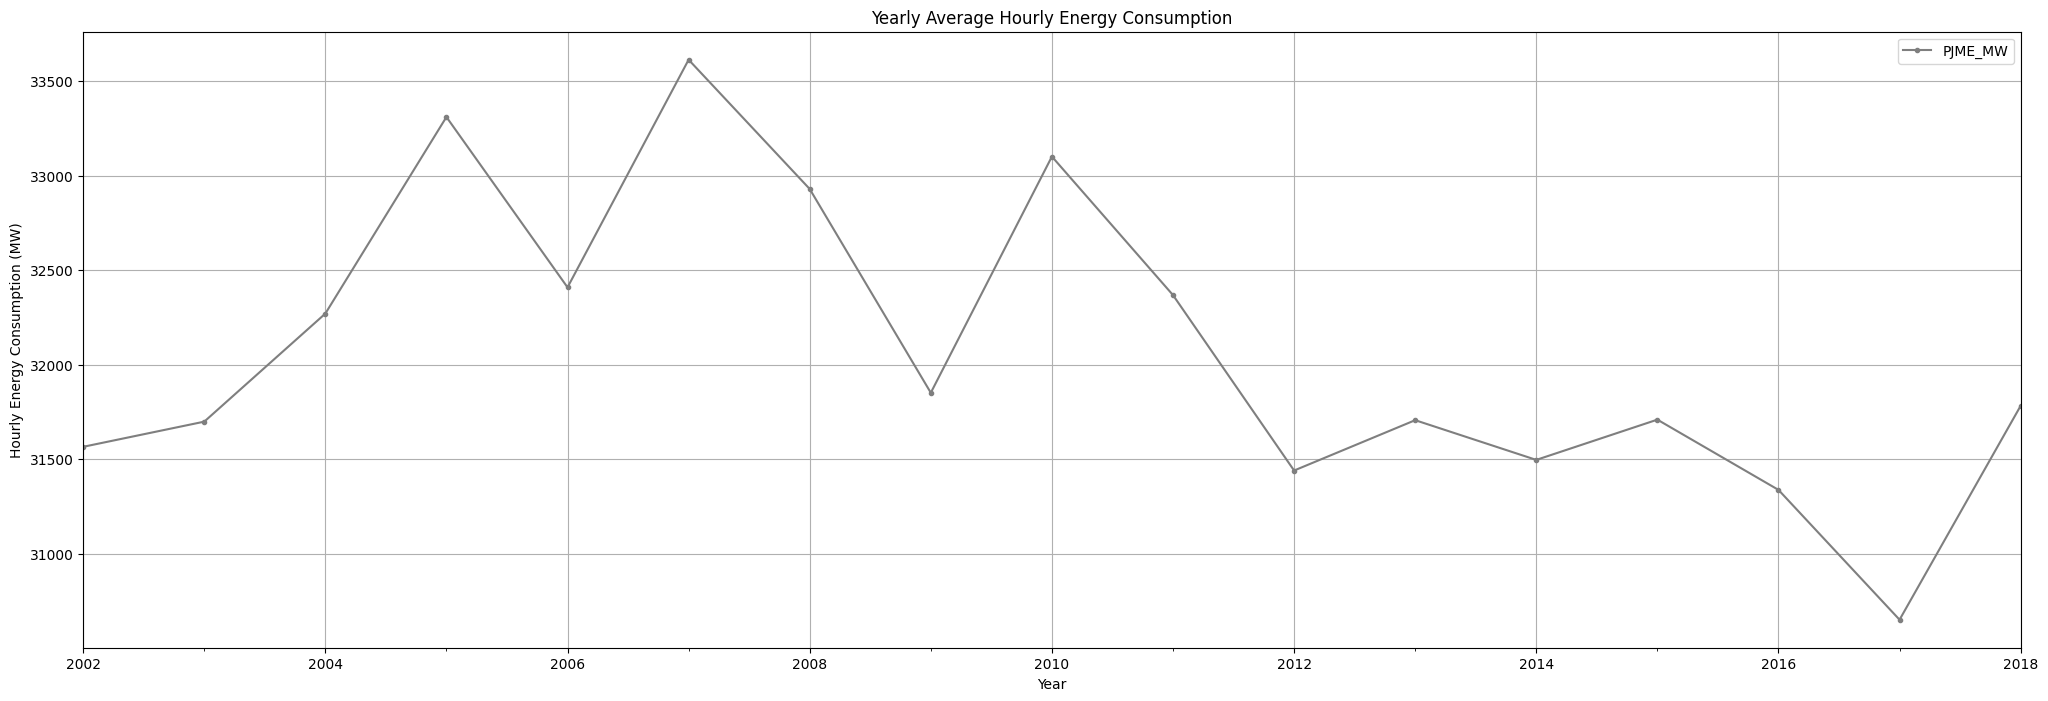

In [19]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot(figsize=(25,8),color=color_pal[7],marker=".")
plt.title("Yearly Average Hourly Energy Consumption")
plt.xlabel("Year")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.grid()

### Train-Test-Split

In [20]:
train = df.loc[df.index<'01-01-2016']
test = df.loc[df.index>='01-01-2016']

In [21]:
train.shape,test.shape

((122686, 1), (22680, 1))

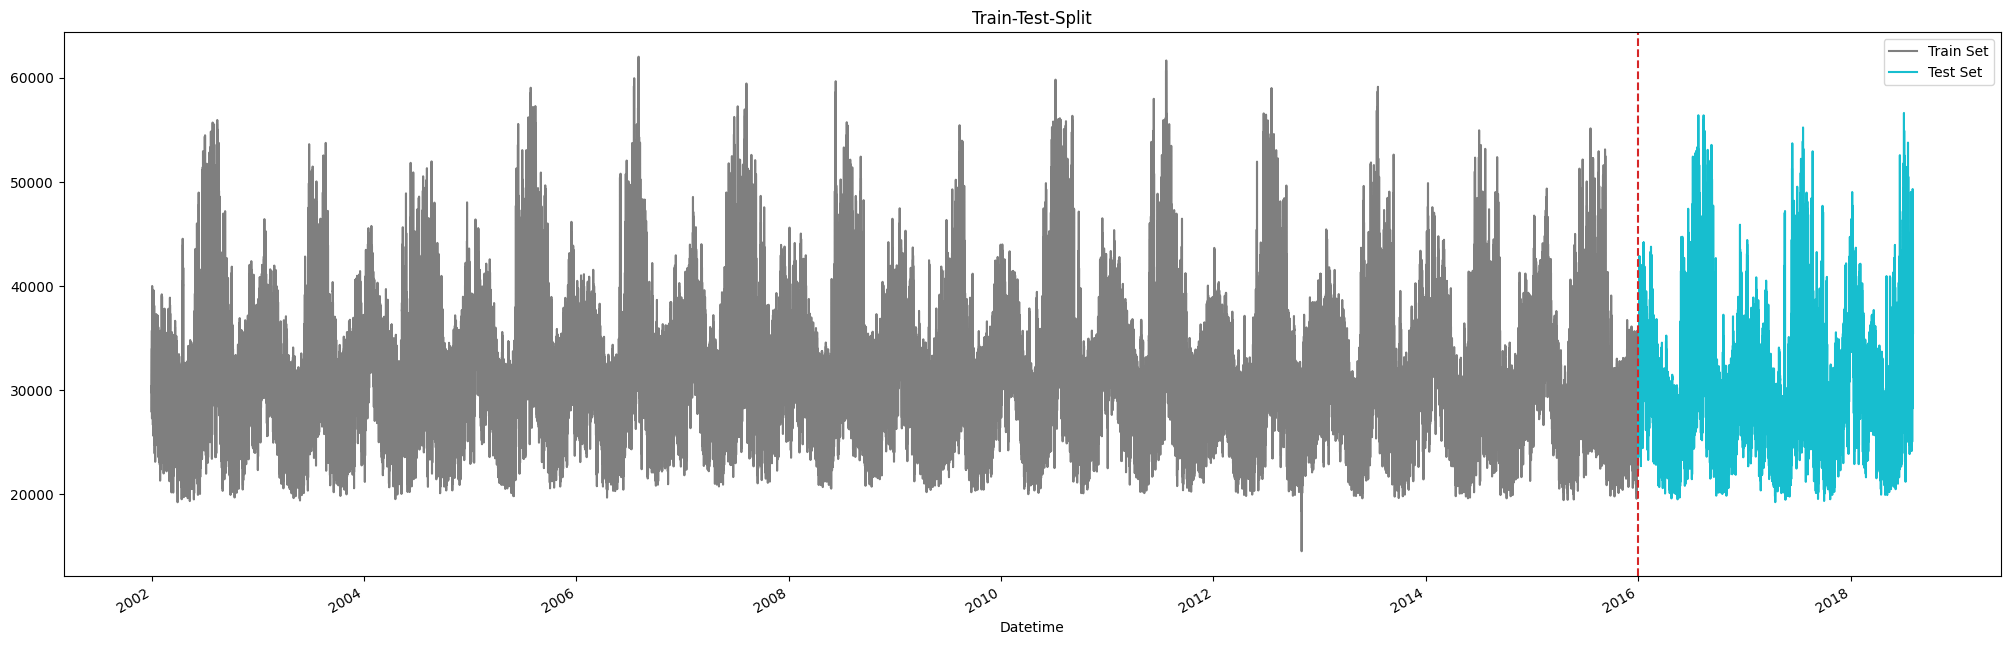

In [23]:
fig,ax = plt.subplots(figsize=(25,8))
train.plot(ax=ax,label='Train Set',color=color_pal[7])
test.plot(ax=ax,label='Test Set',color=color_pal[9])
ax.axvline('01-01-2016',ls='--',color=color_pal[3])
plt.title("Train-Test-Split")
plt.legend(['Train Set','Test Set'],loc='best')
plt.show()

### Feature Engineering

In [24]:
def create_features(df):
    df.loc[:,'hour'] = df.index.hour
    df.loc[:,'dayofweek'] = df.index.day_of_week # monday == 0 & sunday ==6
    df.loc[:,'dayofyear'] = df.index.dayofyear
    df.loc[:,'month'] = df.index.month
    df.loc[:,'quarter'] = df.index.quarter
    df.loc[:,'year'] = df.index.year
    return df

In [25]:
df = create_features(df)

In [26]:
df.head()

,PJME_MW,hour,dayofweek,dayofyear,month,quarter,year
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,365,12,4,2002
2002-12-31 02:00:00,25147.0,2,1,365,12,4,2002
2002-12-31 03:00:00,24574.0,3,1,365,12,4,2002
2002-12-31 04:00:00,24393.0,4,1,365,12,4,2002
2002-12-31 05:00:00,24860.0,5,1,365,12,4,2002


In [27]:
train = create_features(train)

In [28]:
test = create_features(test)

In [29]:
train.head()

,PJME_MW,hour,dayofweek,dayofyear,month,quarter,year
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,365,12,4,2002
2002-12-31 02:00:00,25147.0,2,1,365,12,4,2002
2002-12-31 03:00:00,24574.0,3,1,365,12,4,2002
2002-12-31 04:00:00,24393.0,4,1,365,12,4,2002
2002-12-31 05:00:00,24860.0,5,1,365,12,4,2002


In [30]:
test.head()

,PJME_MW,hour,dayofweek,dayofyear,month,quarter,year
Datetime,,,,,,,
2016-01-01 00:00:00,26686.0,0,4,1,1,1,2016
2016-12-31 01:00:00,29627.0,1,5,366,12,4,2016
2016-12-31 02:00:00,28744.0,2,5,366,12,4,2016
2016-12-31 03:00:00,28274.0,3,5,366,12,4,2016
2016-12-31 04:00:00,28162.0,4,5,366,12,4,2016


### Feature-Target-Split

In [31]:
features = ['hour','dayofweek','dayofyear','month','quarter','year']
target = 'PJME_MW'

In [32]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [33]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((122686, 6), (122686,), (22680, 6), (22680,))

### Model Creation

In [34]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.01)

### Model Training

In [35]:
reg.fit(X_train,
        y_train,
        eval_set=[(X_train,y_train),(X_test,y_test)],
        verbose=10)

[0]	validation_0-rmse:32564.07595	validation_1-rmse:31495.57472
[10]	validation_0-rmse:29490.70017	validation_1-rmse:28426.49748
[20]	validation_0-rmse:26714.41046	validation_1-rmse:25658.85699
[30]	validation_0-rmse:24206.83387	validation_1-rmse:23158.64074
[40]	validation_0-rmse:21943.13511	validation_1-rmse:20899.14467
[50]	validation_0-rmse:19899.93320	validation_1-rmse:18862.42876
[60]	validation_0-rmse:18056.50644	validation_1-rmse:17028.16970
[70]	validation_0-rmse:16394.35619	validation_1-rmse:15379.84083
[80]	validation_0-rmse:14896.39943	validation_1-rmse:13902.19597
[90]	validation_0-rmse:13547.34619	validation_1-rmse:12581.64250
[100]	validation_0-rmse:12333.34879	validation_1-rmse:11405.23479
[110]	validation_0-rmse:11241.77581	validation_1-rmse:10364.82084
[120]	validation_0-rmse:10261.92203	validation_1-rmse:9438.61978
[130]	validation_0-rmse:9383.61274	validation_1-rmse:8605.11724
[140]	validation_0-rmse:8595.73255	validation_1-rmse:7876.30098
[150]	validation_0-rmse:78

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

``Feature Importances :`` How much features are used when trees were trained on given data?

In [36]:
f_i = pd.DataFrame(data = reg.feature_importances_,
             index= reg.feature_names_in_,
             columns = ['feature-importance'])

In [37]:
f_i

,feature-importance
hour,0.500914
dayofweek,0.170228
dayofyear,0.130112
month,0.175560
quarter,0.000000
year,0.023187


<Axes: title={'center': 'Feature Importances'}>

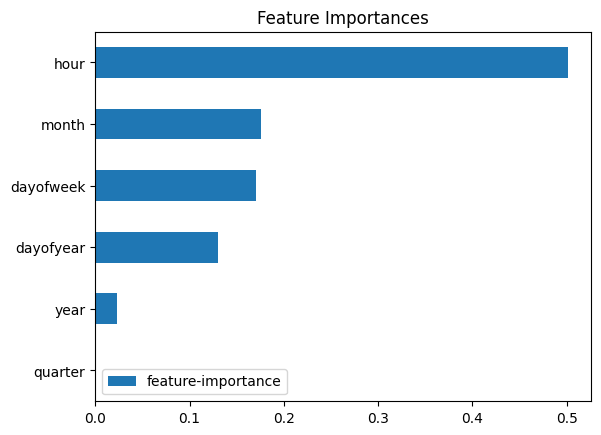

In [38]:
f_i.sort_values('feature-importance',ascending=True).plot(kind='barh',
                                                           title="Feature Importances")

### Forecast on Test Dataset

In [39]:
test.loc[:,'prediction'] = reg.predict(X_test)

In [40]:
test.head()

,PJME_MW,hour,dayofweek,dayofyear,month,quarter,year,prediction
Datetime,,,,,,,,
2016-01-01 00:00:00,26686.0,0,4,1,1,1,2016,31271.472656
2016-12-31 01:00:00,29627.0,1,5,366,12,4,2016,24330.912109
2016-12-31 02:00:00,28744.0,2,5,366,12,4,2016,23496.861328
2016-12-31 03:00:00,28274.0,3,5,366,12,4,2016,23369.128906
2016-12-31 04:00:00,28162.0,4,5,366,12,4,2016,23354.791016


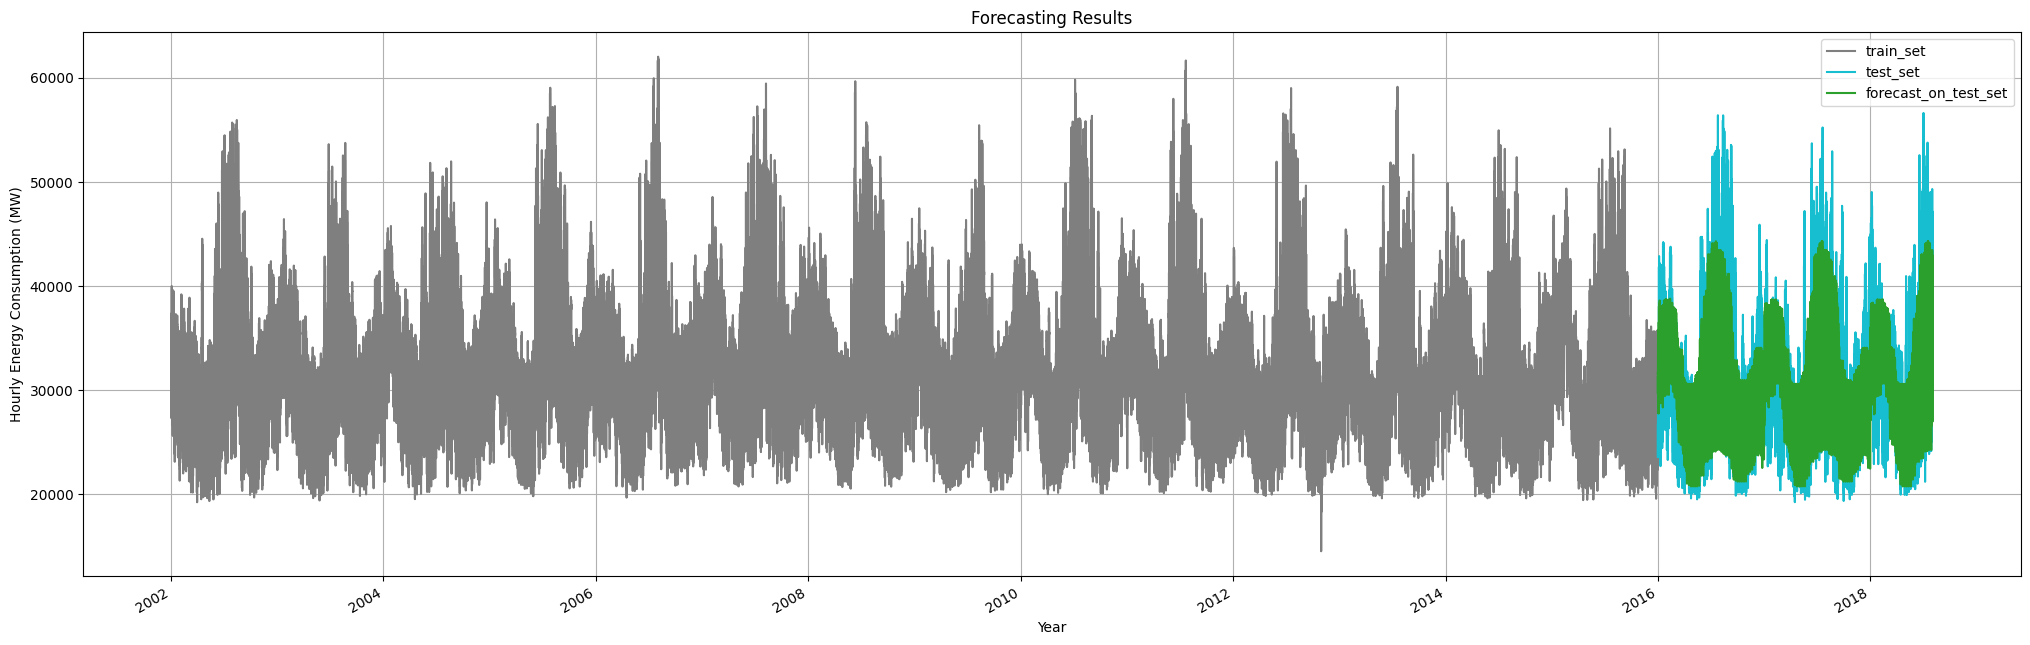

In [41]:
fig,ax= plt.subplots(figsize=(25,8))
train['PJME_MW'].plot(ax=ax,color=color_pal[7])
test['PJME_MW'].plot(ax=ax,color=color_pal[9])
test['prediction'].plot(ax=ax,color=color_pal[2])
plt.title("Forecasting Results")
plt.xlabel("Year")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.legend(['train_set','test_set','forecast_on_test_set'],loc='best')
plt.grid()
plt.show()

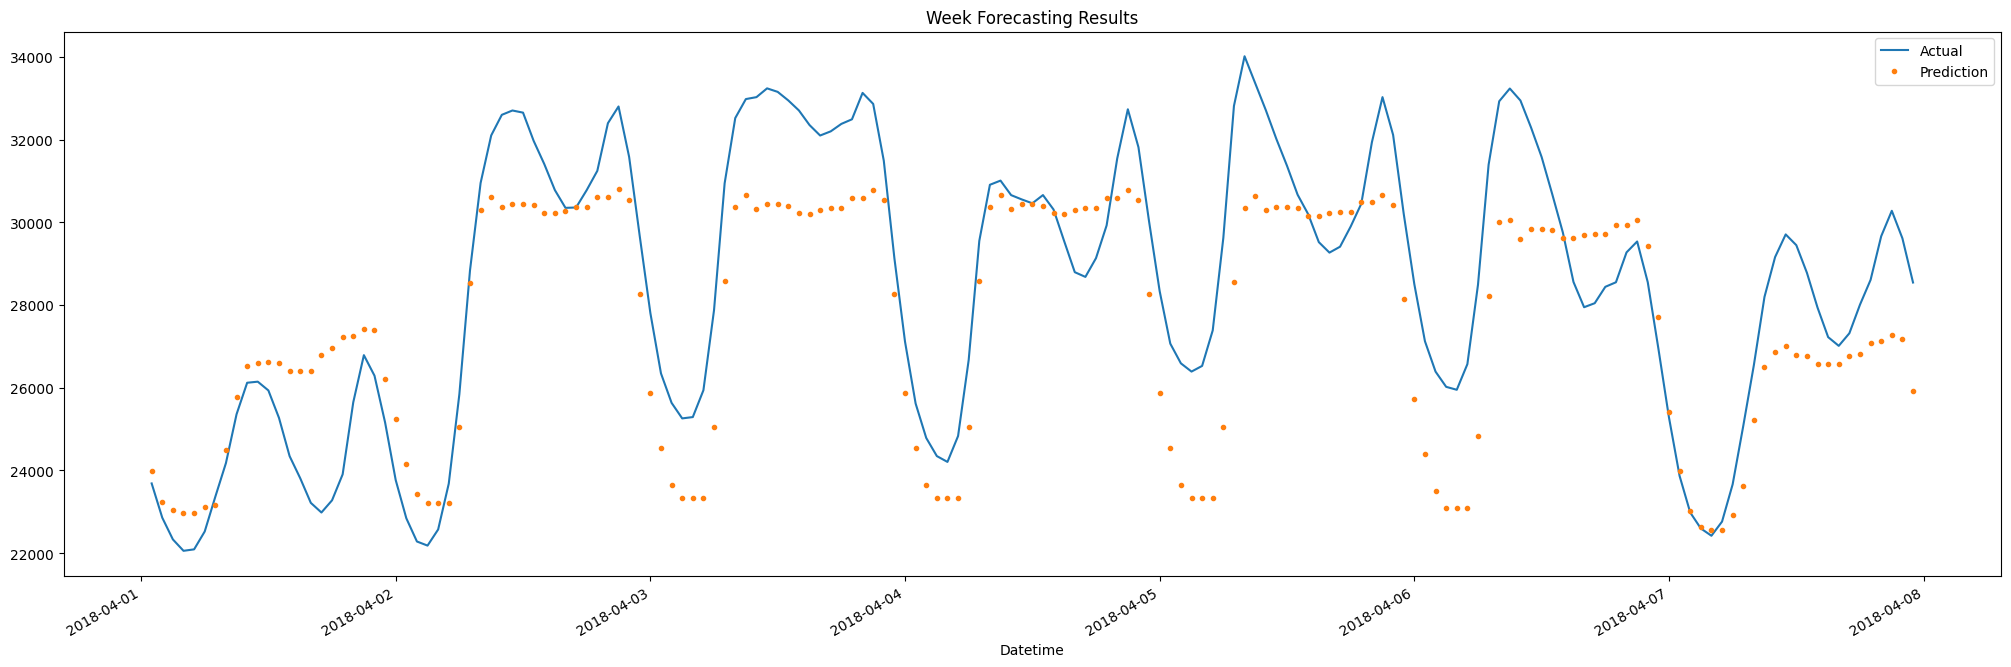

In [42]:
ax = test.loc[(test.index>'04-01-2018')&(test.index<'04-08-2018')]['PJME_MW'].plot(figsize=(25,8),title="Week Forecasting Results")
test.loc[(test.index>'04-01-2018')&(test.index<'04-08-2018')]['prediction'].plot(ax=ax,style='.')
plt.legend(["Actual","Prediction"])
plt.show()

``Root Mean Squared Error :``

In [43]:
np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))

3881.051385239477

### Comments

Performance can improved by taking following steps: 
- More Robust Cross Validation
- Eliminating Features with low Feature Importance
- Adding More Features (weather forecast, holidays)
- Using other models (Catboost, RandomForest, etc.)